# Laboratorio #2 Machine Learning Avanzado


## <font color='blue'>**Introducción**</font>
- La clasificación de imágenes es una tarea fundamental que implica categorizar y etiquetar grupos de píxeles dentro de una imagen en función de reglas específicas. Un área particularmente interesante de la clasificación de imágenes es la distinción entre objetos de apariencia similar.  
- El objetivo de este análisis es desarrollar y comparar dos enfoques distintos de modelos de aprendizaje profundo para la clasificación de imágenes: el Perceptrón Multicapa (MLP) y las Redes Neuronales Convolucionales (CNN). Para ello se utilizará el dataset de Kaggle "Chihuahua vs Muffin" (https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification)
- Ambos tipos de modelos (MLP y CNN) deberán hacerse cargo de un problema de clasificación binaria en que se quiere predecir si cada imagen se trata en realidad de una clase u otra (chihuahua o muffin).
- La hipótesis inicial es que se obtendrá una mejor performance de las redes tipo CNN, dado que precisamente están recomendadas para datos espaciales.
- A su vez, a cada red se le aplicará un ajuste de hiperparámetros, de modo de ver si su rendimiento mejora.


In [ ]:
#pip install opencv-python


In [ ]:
#Importe de librerías
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, Flatten, MaxPooling2D
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


from tensorflow.keras.preprocessing.image import ImageDataGenerator

import os

from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

from sklearn.metrics import roc_curve, auc

from tensorflow.keras.models import Model
import tensorflow.keras.backend as K
import cv2


## <font color='blue'>**I. Carga de Datos**</font>
En el siguiente laboratorio se usará un dataset disponible en Kaggle creado con fines didácticos, que consiste en un conjunto de imágenes de **perros raza chihuahuas y muffins**.

Al contener las imágenes de ambas clases elementos en común (color beige, formas redondas,  puntos marrones que en los chihuahua serían los ojos y en los muffinns los chips de chocolate, etc.) la idea es utilizar la base para crear un modelo de aprendizaje supervisado que sea capaz de discriminar bien si una imagen se trata de una clase u otra (chihuahua, muffin) en contra de la dificultad que representa que ambas clases posean bastante "patrones en común".

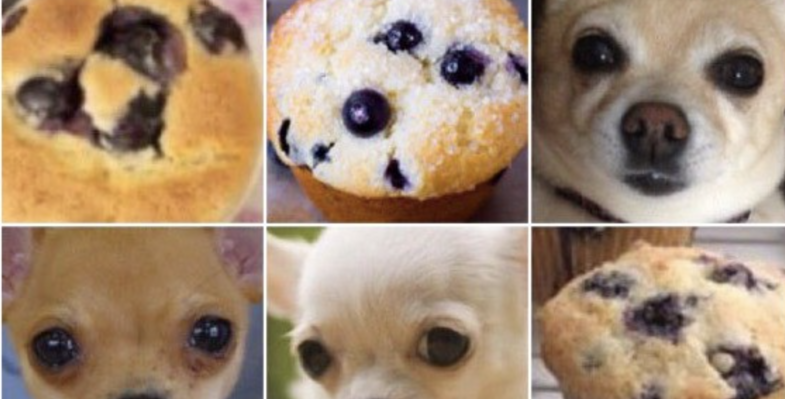

El set de imágenes se descargó de:

https://www.kaggle.com/datasets/samuelcortinhas/muffin-vs-chihuahua-image-classification


La base se compone de cerca de 6.000 imágenes extraídas de Google, se han eliminado las imágenes duplicadas.

Su distribución según objetivo y clase es:





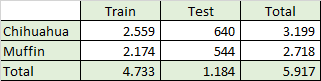

Se observa cómo cerca del 80% es destinado para entrenamiento, y el 20% restante para prueba.

Por otra parte, predomina en cierto grado la clase chihuahua por sobre muffin en un razón 54/46 aproximadamente.

Definimos las rutas en que hemos guardado las imágenes:

In [ ]:
train_chihuahua=('PATH_FILE/train/chihuahua')
train_muffin=('PATH_FILE/train/muffin')
test_chihuahua=('PATH_FILE/test/chihuahua')
test_muffin=('PATH_FILE/test/muffin')

In [ ]:
base_dir = 'PATH_FILE'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_chihuahua_dir = os.path.join(train_dir, 'chihuahua')
train_muffin_dir = os.path.join(train_dir, 'muffin')
test_chihuahua_dir = os.path.join(test_dir, 'chihuahua')
test_muffin_dir = os.path.join(test_dir, 'muffin')



Algunos parámetros a usar:

In [ ]:
img_rows,img_cols = 28,28

In [ ]:
img_size = (64, 64)
batch_size = 32




## <font color='blue'>**II. Generación data para ambos modelos: MLP y CNN**</font>

### <font color='blue'>**a. Datos train y test para Red MLP:**</font>

##### **Datos de entrenamiento (Aplanando las imagenes en vectores unidimensionales)**

* La clase **ImageDataGenerator **de Keras permite normalizar los pixeles de las imágenes, dividiendo cada uno por 255, de manera de obtener valores en el rango [0,1]. EN procesamiento de imágenes normalizar permite eficientar el entrenamiento y ayudar a la convergencia

* A su vez, el método  **flow_from_directory** permite colectar los datos desde un repositorio de imágenes.

In [ ]:
train_datagen_mlp = ImageDataGenerator(rescale=1./255)  #normalizamos cada pixel

train_generator_mlp = train_datagen_mlp.flow_from_directory( #juntamos todas las imágenes del directorio train
    train_dir, #le entregamos la ruta del direcorio
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary', #Indicamos que se trata de un problema de clasificación binaria
    shuffle=True #"Revuelve" los datos en cada época
            )

Found 4733 images belonging to 2 classes.


##### **Datos de testeo**

In [ ]:
test_datagen_mlp = ImageDataGenerator(rescale=1./255)

test_generator_mlp = test_datagen_mlp.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False)

Found 1184 images belonging to 2 classes.


### <font color='blue'>**b. Datos train y test para Red CNN:**</font>

##### **Datos de entrenamiento**

Además de normalizar los pixeles con "rescale", la clase ImageDataGenerator ofrece la posibilidad de realizar **Data Augmentation**.

Esta técnica aplica a cada imagen transformaciones aleatorias de modo que nunca se tendrá 2 veces la misma imagen durante el entrenamiento. Esto con el objeto de entrenar un modelo más robusto que no aprenda del "ruido".

Las distorsiones pueden ser zoom, rotaciones y traslaciones, entre otras.

De este modo **aplicaremos ciertas deformaciones a la data de entrenamiento**, otorgando ciertos argumentos a ImageDataGenerator :



In [ ]:
train_datagen_augmented = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40, #se rota aleatoriamente las imágenes (hasta 40°) en cualquier dirección
    width_shift_range=0.2, # las imágenes pueden ser trasladadas horizontalmente hasta un 20% del ancho total
    height_shift_range=0.2, #las imágenes pueden ser trasladadas verticalmente hasta un 20% de la altura total
    shear_range=0.2, # Rango de deformación de cizalladura aleatoria
    zoom_range=0.2, #Rango de zoom aleatorio
    horizontal_flip=True, #Voltea aleatoriamente las imágenes horizontalmente
    fill_mode='nearest' # Estrategia de llenado de pixelex que se creen con esa data augmentation
                        #En este caso, se utiliza la estrategia 'nearest', que llena los píxeles con los valores más cercanos
)

train_generator_augmented = train_datagen_augmented.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 4733 images belonging to 2 classes.


##### **Datos de testeo**

In [ ]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='binary'
)


Found 1184 images belonging to 2 classes.


De este modo ya tenemos la data de entrenamiento y testeo en los objetos:

* Para Red MLP:
 - train_generator_mlp
 - test_generator_mlp

* Para Red CNN:
 - train_generator_augmented
 - test_generator

## <font color='blue'>**III. Entrenamiento de modelos: MLP y CNN**</font>

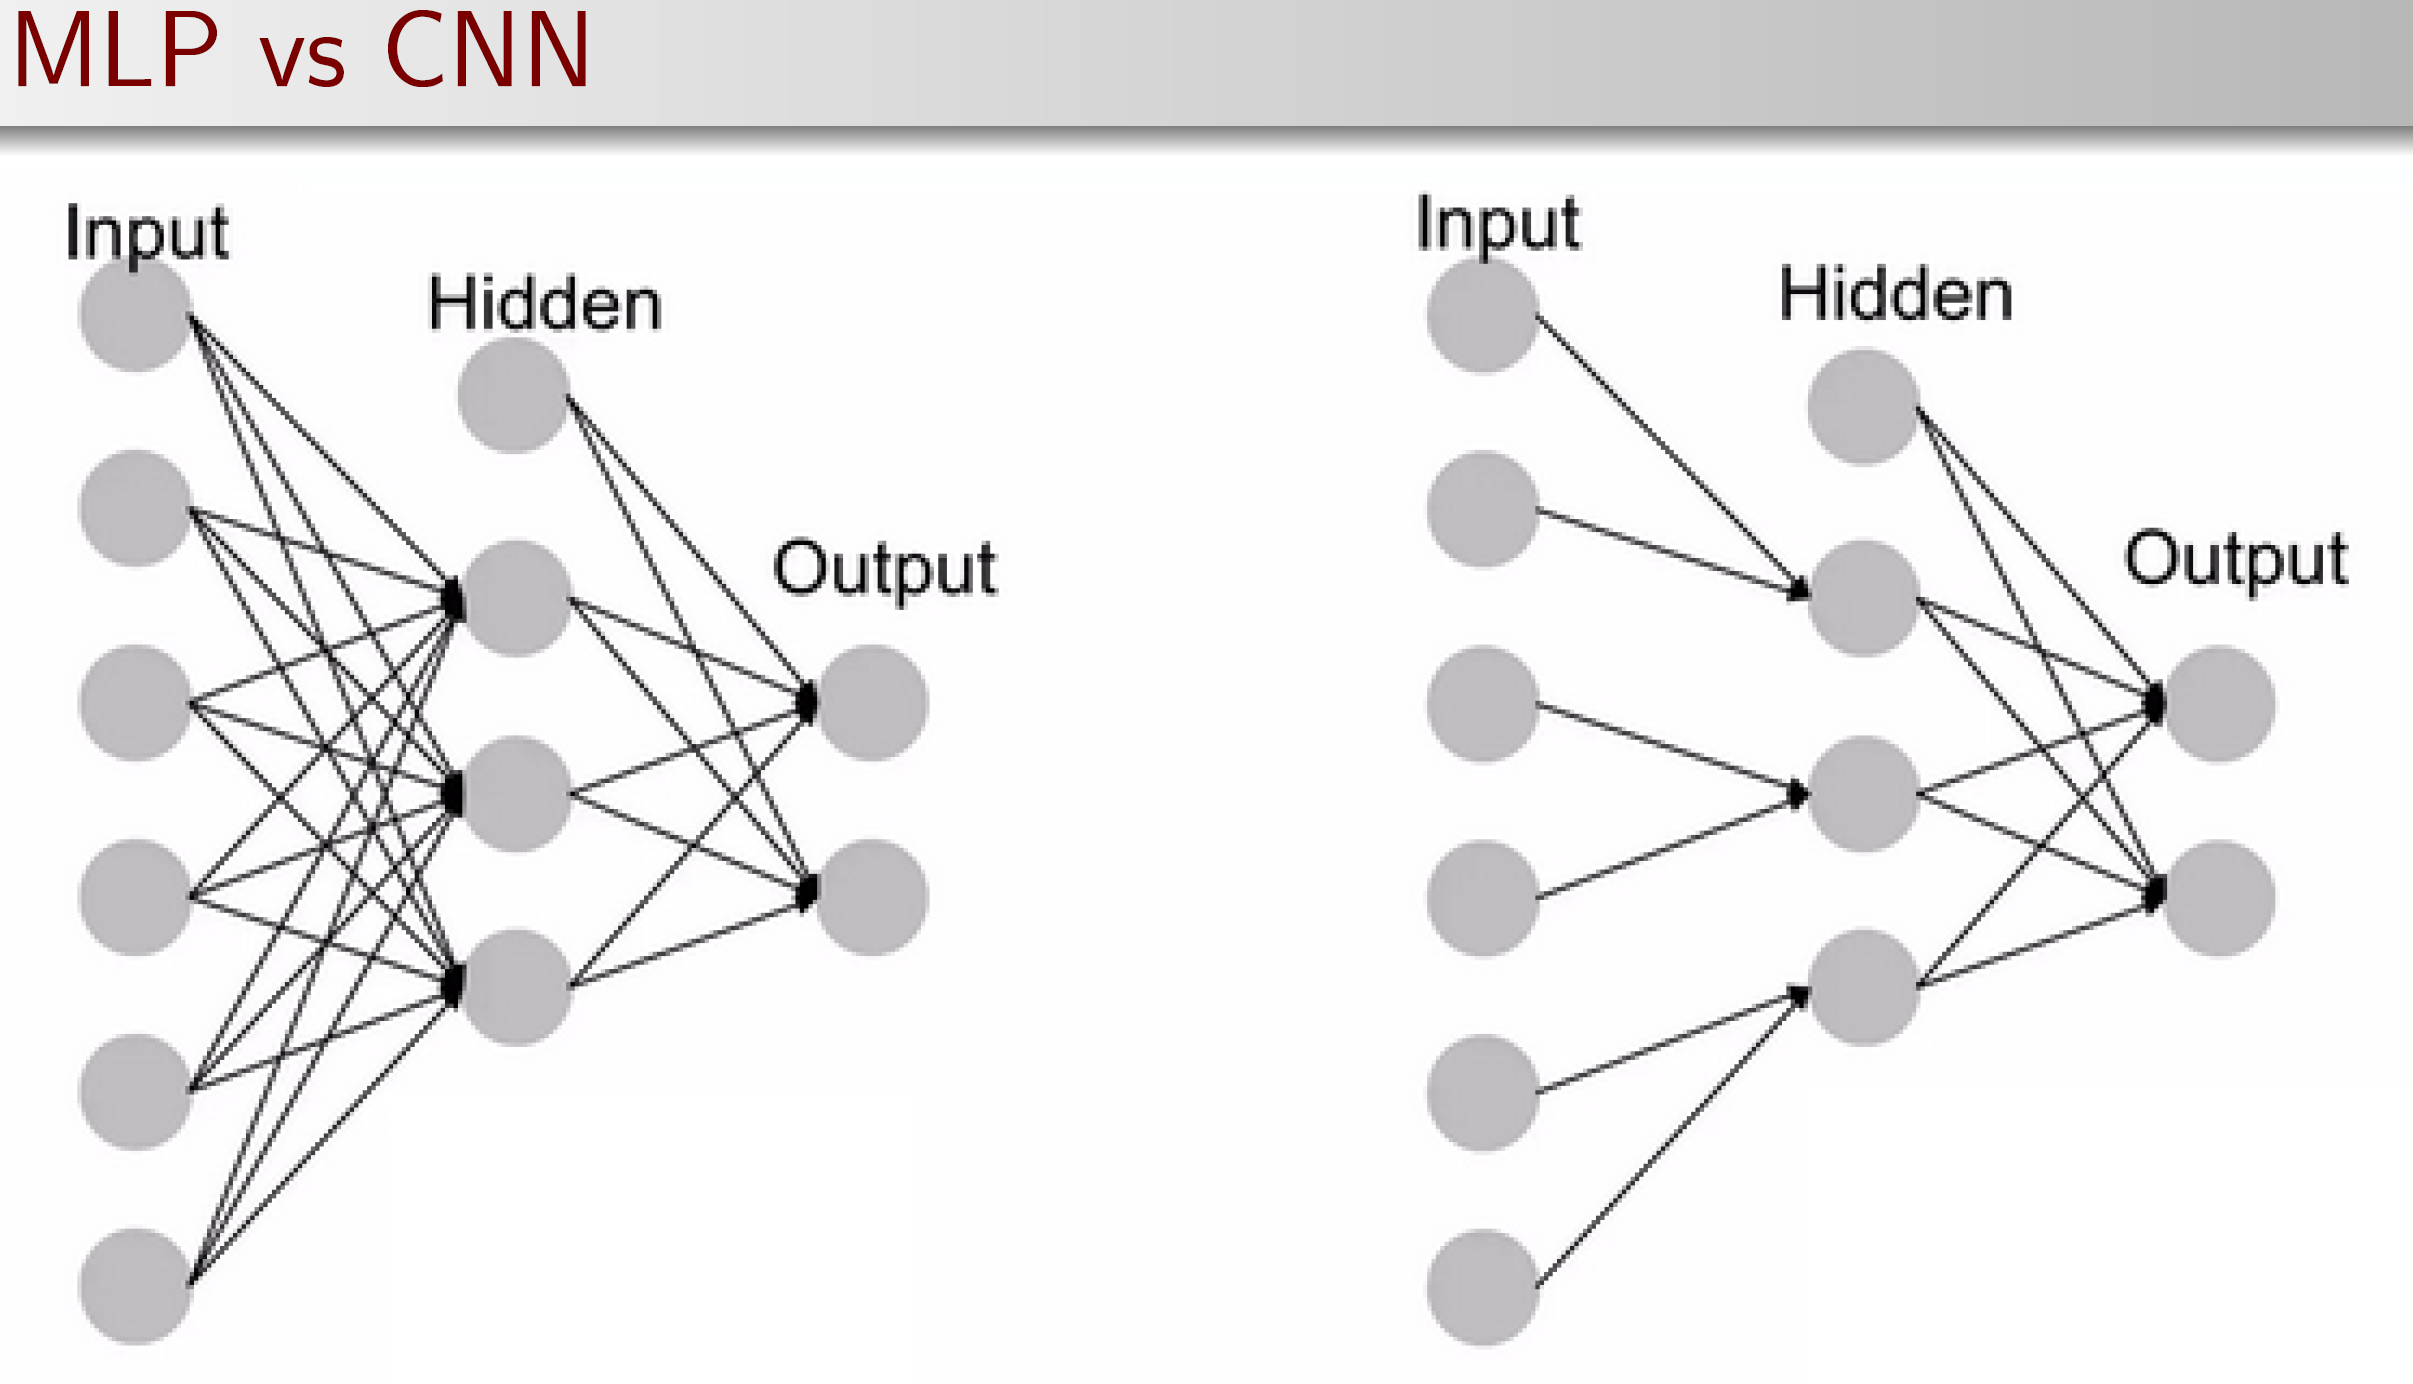


Las redes **MLP (perceptrón multicapa)** están basadas en una arquitectura en que sus capa se encuentran totalmente conectadas (densas) y están concebidas para datos de entrada tipo vector

Por otra parte las **Redes CNN (convolucionales)** están basadas típicamente en una arquitectura de:
-  capas convolucionales
-  capas pooling (o de reducción)
-  una última densa (o fully connected)

A su vez están concebidas para recibir como input datos bidimensionales (imágenes).


Al tener arquitecturas tan distintas, son indicadas para distintos tipos de problemas. Las MLP son indicadas para modelamiento de datos tabulares o series, mientras que las CNN están recomendadas para problemas de imágenes y datos espaciales.

#### <font color='blue'>**a. Entrenando Perceptrón Multicapa (MLP)**</font>

##### Construcción del MLP:

Nuestra red MLP consistirá en:
- Una capa de entrada de "aplanamiento" que me permite transformar la data bidimensional, para poder trabajar con ella en la arquitectura MLP.
- Una capa densa (fully connected) de 512 nodos , con activación RELU.
- Otra capa densa (fully connected) de 256 nodos , con activación RELU.
- Una capa de salida con 1 neurona y activación SIGMOIDE, útil en estos casos de clasificación binaria

In [ ]:
model_mlp = Sequential([
    Flatten(input_shape=(64,64, 3)),     # Aplana la imagen de entrada
    Dense(512, activation='relu'),       # Primera capa oculta
    Dense(256, activation='relu'),       # Segunda capa oculta
    Dense(1, activation='sigmoid')       # Capa de salida
])



##### Entrenamiento del MLP:

In [ ]:
model_mlp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model_mlp.fit(x=train_generator_mlp,
              steps_per_epoch=train_generator_mlp.n//batch_size,
              validation_data=test_generator_mlp,
              validation_steps=test_generator_mlp.n//batch_size,
              epochs=10)

Epoch 1/10


147/147 [==============================] - 34s 228ms/step - loss: 1.1315 - accuracy: 0.5954 - val_loss: 0.6811 - val_accuracy: 0.6292
Epoch 2/10
147/147 [==============================] - 50s 341ms/step - loss: 0.5477 - accuracy: 0.7205 - val_loss: 0.8208 - val_accuracy: 0.5532
Epoch 3/10
147/147 [==============================] - 48s 329ms/step - loss: 0.5485 - accuracy: 0.7298 - val_loss: 0.5274 - val_accuracy: 0.7382
Epoch 4/10
147/147 [==============================] - 46s 312ms/step - loss: 0.4971 - accuracy: 0.7583 - val_loss: 0.4982 - val_accuracy: 0.7753
Epoch 5/10
147/147 [==============================] - 48s 326ms/step - loss: 0.5006 - accuracy: 0.7592 - val_loss: 0.5061 - val_accuracy: 0.7534
Epoch 6/10
147/147 [==============================] - 50s 343ms/step - loss: 0.4886 - accuracy: 0.7679 - val_loss: 0.6276 - val_accuracy: 0.6740
Epoch 7/10
147/147 [==============================] - 50s 343ms/step - loss: 0.4761 - accuracy: 0.7743 - val_loss: 0.5423 - val_accuracy: 0.7

#### <font color='blue'>**b. Entrenando Red Neuronal Convolucional (CNN)**</font>

##### Construcción de la CNN:

La arquitectura de nuestra Red convolucional será:
- **Capa de convolución 1** que: aplicará convoluciones con 32 filtros de 3x3 pixeles , desplazamiento 1 pixel tanto horizontal y vertical, activación tipo Relu, y la entrada imágenes de 64x64 con 3 canales de color RGB.

- **Capa pool 1:** una capa de agrupación máxima tomando el valor máximo en ventanas de 2x2 píxeles con un desplazamiento de 1 píxel.

- **Capa de convolución 2** que: aplicará convoluciones con 64 filtros de 3x3 pixeles , desplazamiento 1 pixel tanto horizontal y vertical, activación tipo Relu, y la entrada imágenes de 64x64 con 3 canales de color RGB.

- **Capa pool 2:** una capa de agrupación máxima tomando el valor máximo en ventanas de 2x2 píxeles con un desplazamiento de 1 píxel.

- **Capa de convolución 3** que: aplicará convoluciones con 128 filtros de 3x3 pixeles , desplazamiento 1 pixel tanto horizontal y vertical, activación tipo Relu, y la entrada imágenes de 64x64 con 3 canales de color RGB.

- **Capa pool 32:** una capa de agrupación máxima tomando el valor máximo en ventanas de 2x2 píxeles con un desplazamiento de 1 píxel.

- **Capa de aplanamiento (flatten):**que convierte la salida de las capas anteriores (generalmente tridimensional) en un vector unidimensional.

- **Capa densa**: una capa densa de 512 nodos, con función de activación relu

- **Capa salida**: de 1 nodo con activación sigmoide.


A continuación el código para agregar cada capa:

In [ ]:
model_cnn = tf.keras.models.Sequential()

In [ ]:
# Primera convolución:
model_cnn.add(tf.keras.layers.Conv2D(filters=32,
                                 kernel_size=3,
                                 strides=(1,1),
                                 activation='relu',
                                 input_shape=(64,64,3)))

In [ ]:
# Pooling:
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=1))

In [ ]:
# Segunda convolución:
model_cnn.add(tf.keras.layers.Conv2D(filters=64,
                                 kernel_size=3,
                                 strides=(1,1),
                                 activation='relu',
                                 ))

In [ ]:
# Pooling:
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=1))

In [ ]:
# Tercera convolución:
model_cnn.add(tf.keras.layers.Conv2D(filters=128,
                                 kernel_size=3,
                                 strides=(1,1),
                                 activation='relu',
                                 ))

In [ ]:
# Pooling:
model_cnn.add(tf.keras.layers.MaxPool2D(pool_size=2,strides=1))

In [ ]:
# Flatten:
model_cnn.add(tf.keras.layers.Flatten())

In [ ]:
# Full Connection:
model_cnn.add(tf.keras.layers.Dense(units=512, activation='relu'))

In [ ]:
# Output layer:
model_cnn.add(tf.keras.layers.Dense(units=1,activation='sigmoid'))

##### Entrenamiento de la CNN:

Recordemos que el batch size se definió en 32

El modelo de red convolucional será configurado bajo el optimizador "Adam", usando la funcion de pérdida "entropía cruzada binaria" en el entrenamiento, y pidiendo que use la métrica accuraccy (certeza) al momento de evaluar cada época (tanto en train como en test):

In [ ]:
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model_cnn.fit(
    train_generator_augmented, #entrenamos con la data a la que le aplicamos previamente distorsión
    steps_per_epoch=train_generator_augmented.n // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/10


147/147 [==============================] - 341s 2s/step - loss: 1.1170 - accuracy: 0.6752 - val_loss: 0.5855 - val_accuracy: 0.7086
Epoch 2/10
147/147 [==============================] - 330s 2s/step - loss: 0.4949 - accuracy: 0.7700 - val_loss: 0.5192 - val_accuracy: 0.7340
Epoch 3/10
147/147 [==============================] - 295s 2s/step - loss: 0.4648 - accuracy: 0.7934 - val_loss: 0.4696 - val_accuracy: 0.7736
Epoch 4/10
147/147 [==============================] - 294s 2s/step - loss: 0.4278 - accuracy: 0.8113 - val_loss: 0.4771 - val_accuracy: 0.7973
Epoch 5/10
147/147 [==============================] - 271s 2s/step - loss: 0.4107 - accuracy: 0.8237 - val_loss: 0.3820 - val_accuracy: 0.8108
Epoch 6/10
147/147 [==============================] - 266s 2s/step - loss: 0.3814 - accuracy: 0.8354 - val_loss: 0.3932 - val_accuracy: 0.8269
Epoch 7/10
147/147 [==============================] - 262s 2s/step - loss: 0.3730 - accuracy: 0.8375 - val_loss: 0.5501 - val_accuracy: 0.7432
Epoch 8/10

## <font color='blue'>**IV. Comparativa modelos: MLP y CNN**</font>

#### <font color='blue'>**a. Separación de data necesaria para evaluar:**</font>

In [ ]:
# División de train y test para la data de CNN:

X_train_cnn, Y_train_cnn = [], []
X_test_cnn, Y_test_cnn = [], []

# X_train y Y_train
for _ in range(train_generator_augmented.n // batch_size):
    x, y = next(train_generator_augmented)
    X_train_cnn.append(x)
    Y_train_cnn.append(y)

# listas a arrays de NumPy
X_train_cnn = np.concatenate(X_train_cnn, axis=0)
Y_train_cnn = np.concatenate(Y_train_cnn, axis=0)

# X_test y Y_test
for _ in range(test_generator.n // batch_size):
    x, y = next(test_generator)
    X_test_cnn.append(x)
    Y_test_cnn.append(y)

# listas a arrays de NumPy
X_test_cnn = np.concatenate(X_test_cnn, axis=0)
Y_test_cnn = np.concatenate(Y_test_cnn, axis=0)

In [ ]:
# División  de train y test para la data de MLP:

X_train_mlp, Y_train_mlp = [], []
X_test_mlp, Y_test_mlp = [], []

# X_train y Y_train
for _ in range(train_generator_augmented.n // batch_size):
    x, y = next(train_generator_augmented)
    X_train_mlp.append(x)
    Y_train_mlp.append(y)

# listas a arrays de NumPy
X_train_mlp = np.concatenate(X_train_mlp, axis=0)
Y_train_mlp = np.concatenate(Y_train_mlp, axis=0)

# X_test y Y_test
for _ in range(test_generator.n // batch_size):
    x, y = next(test_generator)
    X_test_mlp.append(x)
    Y_test_mlp.append(y)

# listas a arrays de NumPy
X_test_mlp = np.concatenate(X_test_mlp, axis=0)
Y_test_mlp = np.concatenate(Y_test_mlp, axis=0)


#### <font color='blue'>**b. Evaluación del modelo MLP:**</font>


**Para nuestra red MLP, se ve que su mejor iteración (ÉPOCA 10) obtuvo un accuraccy en la base de validación de 78,12%, lo que implica que acertó en el 78,12% de las predicciones.**

Evaluar accuracy (certeza)
37/37 [==============================] - 0s 7ms/step - loss: 0.5096 - accuracy: 0.7812
Training accuracy: 0.7007019519805908
Testing accuracy: 0.78125


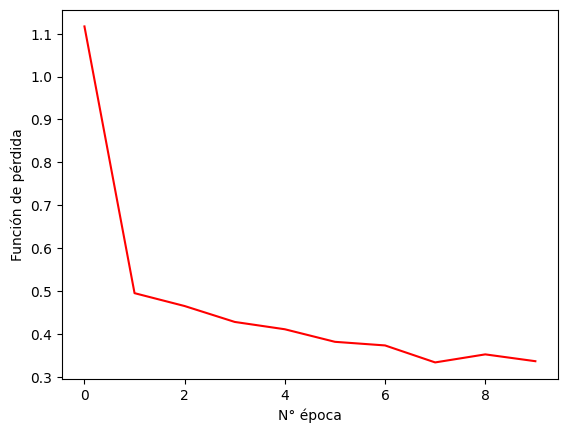

In [ ]:
print('Evaluar accuracy (certeza)')
# Evaluación de accuracy
train_acc = model_mlp.evaluate(X_train_mlp, Y_train_mlp, batch_size=batch_size)[1]
test_acc = model_mlp.evaluate(X_test_mlp, Y_test_mlp, batch_size=batch_size)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

**AL observar el ROC del modelo, arroja 0,85, lo que habla de un modelo que es bueno discriminando entre clases:**

37/37 [==============================] - 4s 121ms/step


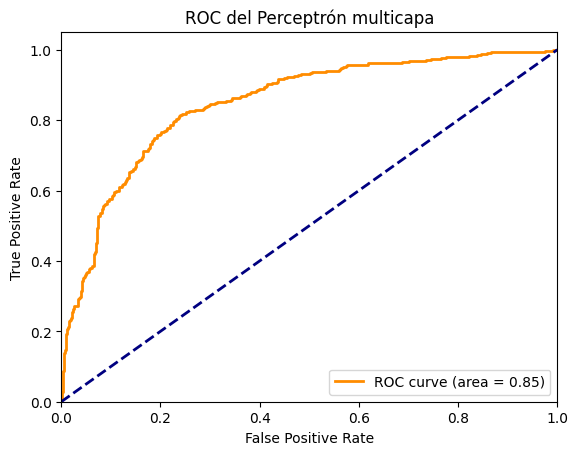

In [ ]:
y_pred = model_mlp.predict(test_generator_mlp).ravel()
y_true = test_generator_mlp.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Curva ROC (Receiver Operating Characteristic)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC del Perceptrón multicapa')
plt.legend(loc="lower right")
plt.show()

##### Evaluación del modelo CNN:

Evaluar accuracy (certeza)


37/37 [==============================] - 9s 246ms/step - loss: 0.3635 - accuracy: 0.8480
Training accuracy: 0.8820152878761292
Testing accuracy: 0.8479729890823364


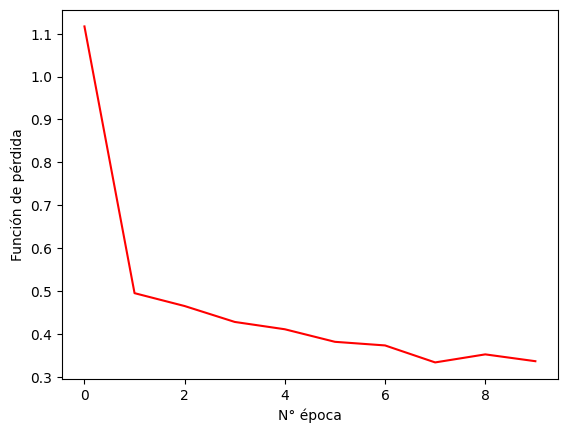

In [ ]:
print('Evaluar accuracy (certeza)')
# Evaluación de accuracy
train_acc = model_cnn.evaluate(X_train_cnn, Y_train_cnn, batch_size=batch_size)[1]
test_acc = model_cnn.evaluate(X_test_cnn, Y_test_cnn, batch_size=batch_size)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

37/37 [==============================] - 12s 308ms/step


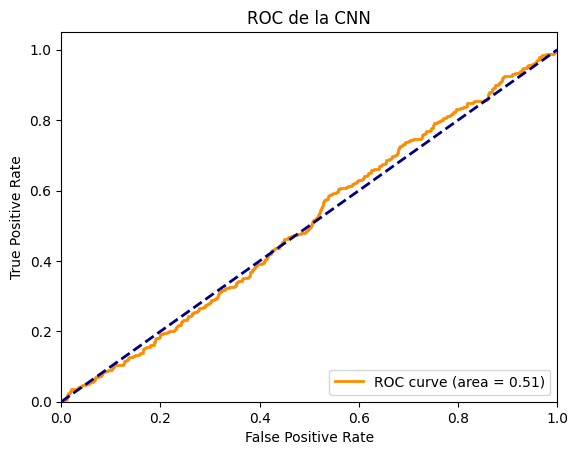

In [ ]:
y_pred = model_cnn.predict(test_generator).ravel()
y_true = test_generator.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC (Receiver Operating Characteristics)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC de la CNN')
plt.legend(loc="lower right")
plt.show()

**En el modelo de CNN obtuvimos un accuraccy superior al de MLP (84,8% sobre 78,1%) pero se debe poner atención en el ROC, qué basicamente al ser de 0,5 me habla de un modelo que no está aprendiendo patrones significativos para diferenciar entre las clases.**

## <font color='blue'>**V. Ajuste de Hiperparámetros**</font>

La idea es revisar si con ciertos ajustes a los hiperparámetros de cada red, se pueden obtener mejores rendimientos.

#### <font color='blue'>**a. Ajuste de Hiperparámetros en Red MLP:**</font>

In [ ]:
model_mlp_adjusted = Sequential([
    Flatten(input_shape=(64, 64, 3)),
    Dense(1024, activation='relu'), #aumentando de 512 a 1024 nodos
    Dropout(0.25),
    Dense(512, activation='relu'), #aumentando de 256 a 512 nodos
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [ ]:
model_mlp_adjusted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
model_mlp_adjusted.fit(x=train_generator_mlp,
              steps_per_epoch=train_generator_mlp.n//batch_size,
              validation_data=test_generator_mlp,
              validation_steps=test_generator_mlp.n//batch_size,
              epochs=10)

Epoch 1/10
147/147 [==============================] - 53s 354ms/step - loss: 1.6794 - accuracy: 0.5486 - val_loss: 0.5903 - val_accuracy: 0.6892
Epoch 2/10
147/147 [==============================] - 28s 193ms/step - loss: 0.6593 - accuracy: 0.6277 - val_loss: 0.6132 - val_accuracy: 0.7154
Epoch 3/10
147/147 [==============================] - 31s 211ms/step - loss: 0.6166 - accuracy: 0.6573 - val_loss: 0.6075 - val_accuracy: 0.6562
Epoch 4/10
147/147 [==============================] - 32s 216ms/step - loss: 0.6169 - accuracy: 0.6494 - val_loss: 0.5980 - val_accuracy: 0.6807
Epoch 5/10
147/147 [==============================] - 33s 227ms/step - loss: 0.6034 - accuracy: 0.6609 - val_loss: 0.5944 - val_accuracy: 0.6841
Epoch 6/10
147/147 [==============================] - 34s 233ms/step - loss: 0.6172 - accuracy: 0.6554 - val_loss: 0.6110 - val_accuracy: 0.6951
Epoch 7/10
147/147 [==============================] - 33s 223ms/step - loss: 0.5995 - accuracy: 0.6809 - val_loss: 0.5528 - val_ac

#### <font color='blue'>**b. Ajuste de Hiperparámetros en Red CNN:**</font>

In [ ]:
model_cnn_adjusted = Sequential([
    Conv2D(64, (1,1), activation='relu', input_shape=(64, 64, 3)), #aumentando de 32 filtros a 64
    MaxPooling2D(2, 2), #strides cambian de 1 a 2
    Conv2D(128, (3,3), activation='relu'), #aumento de filtros de 64 a 128
    MaxPooling2D(2,2), #aumento de strides de 1 a 2 y eliminación de tercera convolución y su respectiva pooling
    Flatten(),
    Dense(1024, activation='relu'), #aumento de 512 units a 1024
    Dense(1, activation='sigmoid')
])


In [ ]:
model_cnn_adjusted.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])


In [ ]:
history = model_cnn_adjusted.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.n // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/10


147/147 [==============================] - 59s 396ms/step - loss: 0.7410 - accuracy: 0.6282 - val_loss: 0.4784 - val_accuracy: 0.7846
Epoch 2/10
147/147 [==============================] - 64s 433ms/step - loss: 0.5070 - accuracy: 0.7566 - val_loss: 0.5063 - val_accuracy: 0.7568
Epoch 3/10
147/147 [==============================] - 68s 462ms/step - loss: 0.4419 - accuracy: 0.7992 - val_loss: 0.3470 - val_accuracy: 0.8522
Epoch 4/10
147/147 [==============================] - 67s 458ms/step - loss: 0.3998 - accuracy: 0.8268 - val_loss: 0.2960 - val_accuracy: 0.8809
Epoch 5/10
147/147 [==============================] - 63s 430ms/step - loss: 0.3932 - accuracy: 0.8251 - val_loss: 0.3945 - val_accuracy: 0.8150
Epoch 6/10
147/147 [==============================] - 63s 431ms/step - loss: 0.3637 - accuracy: 0.8413 - val_loss: 0.3868 - val_accuracy: 0.8150
Epoch 7/10
147/147 [==============================] - 65s 442ms/step - loss: 0.3654 - accuracy: 0.8440 - val_loss: 0.3100 - val_accuracy: 0.8

### <font color='blue'>**Evaluación con optimización de hiperparámetros**</font>

##### Evaluación del modelo MLP ajustado:

Evaluar accuracy (certeza)
37/37 [==============================] - 1s 13ms/step - loss: 0.5391 - accuracy: 0.7449
Training accuracy: 0.6919804215431213
Testing accuracy: 0.7449324131011963


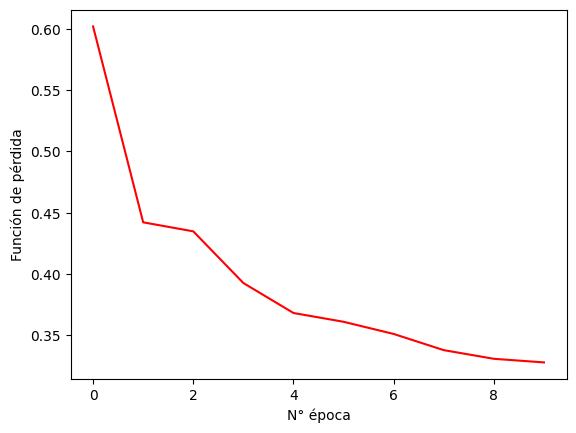

In [ ]:
print('Evaluar accuracy (certeza)')
# Evaluación de accuracy
train_acc = model_mlp_adjusted.evaluate(X_train_mlp, Y_train_mlp, batch_size=batch_size)[1]
test_acc = model_mlp_adjusted.evaluate(X_test_mlp, Y_test_mlp, batch_size=batch_size)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

37/37 [==============================] - 6s 159ms/step


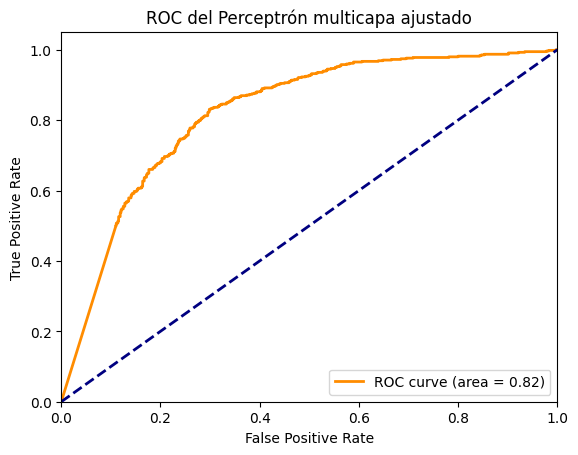

In [ ]:

y_pred = model_mlp_adjusted.predict(test_generator_mlp).ravel()
y_true = test_generator_mlp.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# curva ROC (Receiver Operating Characteristics)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC del Perceptrón multicapa ajustado')
plt.legend(loc="lower right")
plt.show()

##### Evaluación del modelo CNN ajustado:

Evaluar accuracy (certeza)


37/37 [==============================] - 2s 56ms/step - loss: 0.2323 - accuracy: 0.8936
Training accuracy: 0.8732993006706238
Testing accuracy: 0.8935810923576355


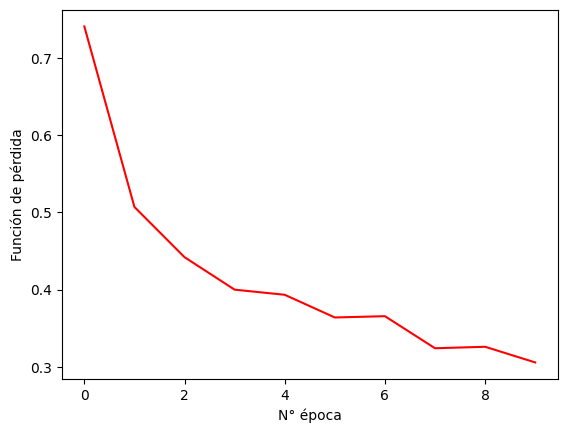

In [ ]:
print('Evaluar accuracy (certeza)')
# Evaluación de accuracy
train_acc = model_cnn_adjusted.evaluate(X_train_cnn, Y_train_cnn, batch_size=batch_size)[1]
test_acc = model_cnn_adjusted.evaluate(X_test_cnn, Y_test_cnn, batch_size=batch_size)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

37/37 [==============================] - 6s 170ms/step


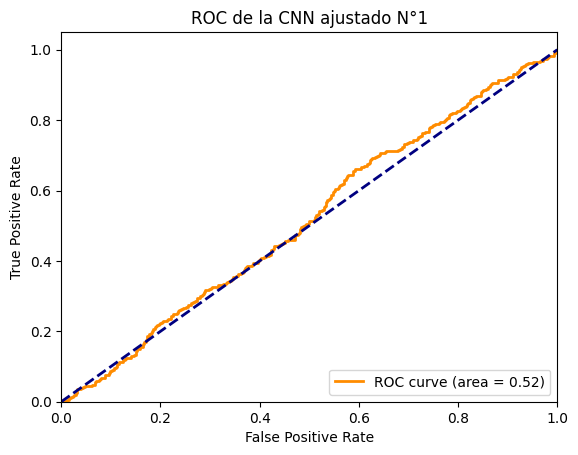

In [ ]:
y_pred = model_cnn_adjusted.predict(test_generator).ravel()
y_true = test_generator.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC (Receiver Operating Characteristics)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC de la CNN ajustado N°1')
plt.legend(loc="lower right")
plt.show()

# Ajuste N°2 al modelo CNN:

In [ ]:
# Initialising the CNN
model_cnn_adjusted_2 = tf.keras.models.Sequential()


# Primera Convolucion:
model_cnn_adjusted_2.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=3,
                               activation='relu',
                               input_shape=[64, 64, 3]))
# Pooling 1
model_cnn_adjusted_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Segunda Convolución
model_cnn_adjusted_2.add(tf.keras.layers.Conv2D(filters=32,
                               kernel_size=3,
                               activation='relu'))

# Pooling 2
model_cnn_adjusted_2.add(tf.keras.layers.MaxPool2D(pool_size=2, strides=2))

# Capa Flatten:
model_cnn_adjusted_2.add(tf.keras.layers.Flatten())

# Capa Full Connection:
model_cnn_adjusted_2.add(tf.keras.layers.Dense(units=128, activation='relu'))

# Capa Output
model_cnn_adjusted_2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

In [ ]:
#Entrenamiento :
model_cnn_adjusted_2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

history = model_cnn_adjusted_2.fit(
    train_generator_augmented,
    steps_per_epoch=train_generator_augmented.n // batch_size,
    epochs=10,
    validation_data=test_generator,
    validation_steps=test_generator.n // batch_size
)

Epoch 1/10


147/147 [==============================] - 31s 203ms/step - loss: 0.6019 - accuracy: 0.6703 - val_loss: 0.5029 - val_accuracy: 0.7517
Epoch 2/10
147/147 [==============================] - 29s 197ms/step - loss: 0.4422 - accuracy: 0.8034 - val_loss: 0.3502 - val_accuracy: 0.8522
Epoch 3/10
147/147 [==============================] - 29s 196ms/step - loss: 0.4348 - accuracy: 0.8066 - val_loss: 0.4667 - val_accuracy: 0.7779
Epoch 4/10
147/147 [==============================] - 29s 196ms/step - loss: 0.3927 - accuracy: 0.8371 - val_loss: 0.3562 - val_accuracy: 0.8395
Epoch 5/10
147/147 [==============================] - 29s 195ms/step - loss: 0.3682 - accuracy: 0.8379 - val_loss: 0.3582 - val_accuracy: 0.8345
Epoch 6/10
147/147 [==============================] - 30s 205ms/step - loss: 0.3611 - accuracy: 0.8432 - val_loss: 0.3572 - val_accuracy: 0.8480
Epoch 7/10
147/147 [==============================] - 29s 197ms/step - loss: 0.3511 - accuracy: 0.8511 - val_loss: 0.2719 - val_accuracy: 0.8

Evaluar accuracy (certeza)
  1/147 [..............................] - ETA: 4s - loss: 0.2134 - accuracy: 0.9062

37/37 [==============================] - 1s 16ms/step - loss: 0.3239 - accuracy: 0.8564
Training accuracy: 0.8764880895614624
Testing accuracy: 0.8564189076423645


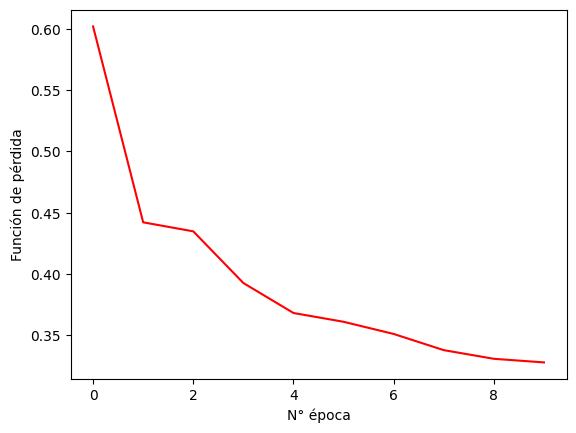

In [ ]:
# Evaluación del segundo modelo CNN ajustado:

print('Evaluar accuracy (certeza)')
# Evaluación de accuracy
train_acc = model_cnn_adjusted_2.evaluate(X_train_cnn, Y_train_cnn, batch_size=batch_size)[1]
test_acc = model_cnn_adjusted_2.evaluate(X_test_cnn, Y_test_cnn, batch_size=batch_size)[1]
print('Training accuracy: %s' % train_acc)
print('Testing accuracy: %s' % test_acc)

losses = history.history['loss']
plt.plot(range(len(losses)), losses, 'r')
plt.xlabel('N° época')
plt.ylabel('Función de pérdida')
plt.show()

37/37 [==============================] - 5s 123ms/step


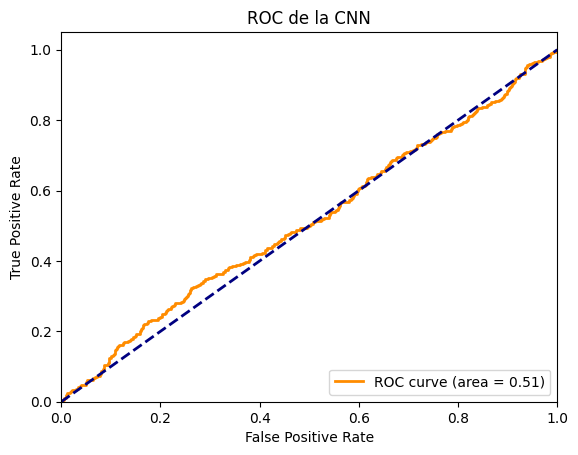

In [ ]:
y_pred = model_cnn_adjusted_2.predict(test_generator).ravel()
y_true = test_generator.classes

fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Graficar la curva ROC (Receiver Operating Characteristics)
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC de la CNN')
plt.legend(loc="lower right")
plt.show()

## <font color='blue'>**VI. Resumen resultados**</font>

- Modelos MLP:

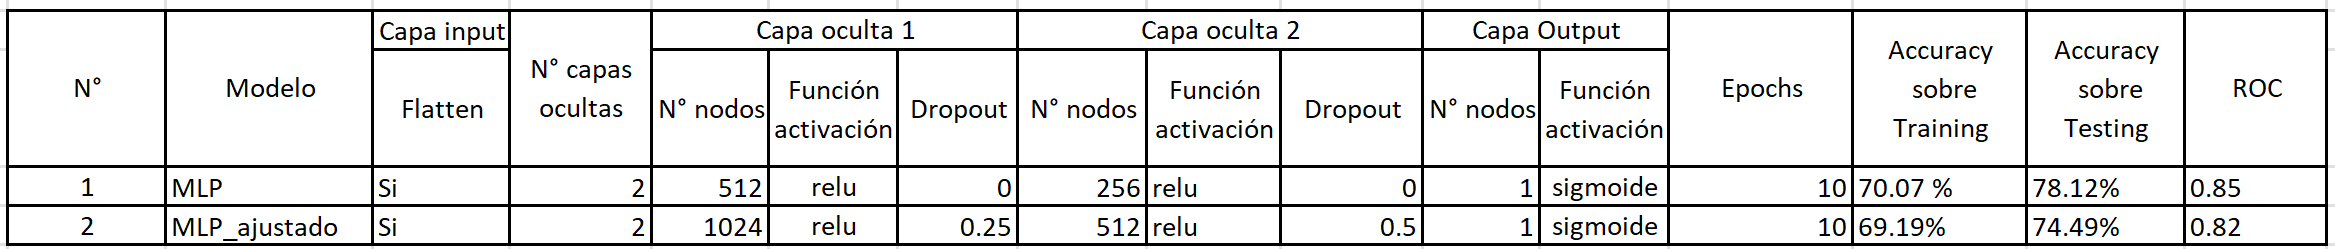

- Modelos CNN:

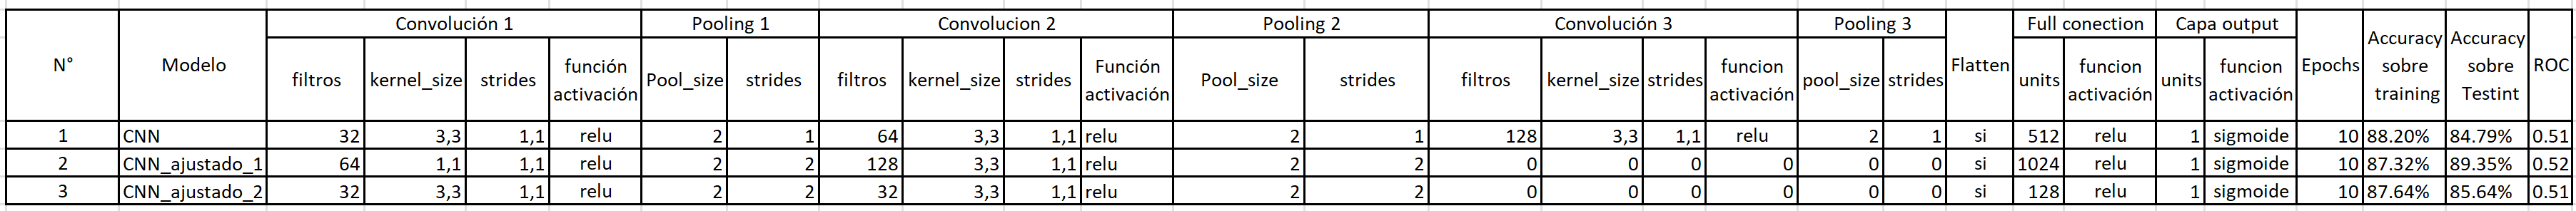

* Con respecto a la red MLP se ve como al agregar más nodos a la capas empeoró al accurracy sobre testing (bajando de 78,12% a 74,49%). Esto habla de un possible overfittig que el dropout incluido no pudo contrarrestar.

* En relación a la red CNN, en el modelo número 2 se evidencia cómo al aumentar en número de filtros y eliminar capa de convolución (con su respectiva pool) así como el aumentar el N de la capa densa, implicó una mejora del accuracy en test del 84,8% al 89,4%.

### Test de Predicción:

A continuación, **sólo para fines exploratorios**, se tienen ejemplos en que la imagen fue clasificada como MUFFIN, siendo CHIHUAHUA:

37/37 [==============================] - 5s 137ms/step


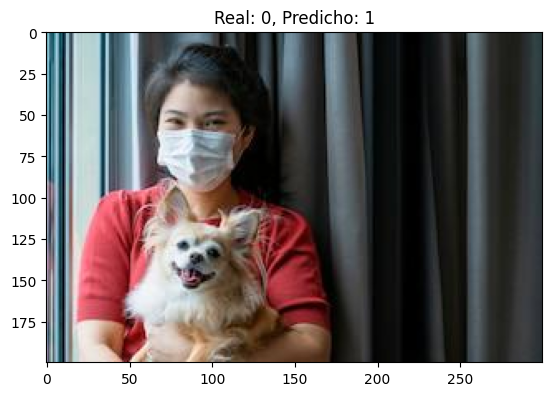

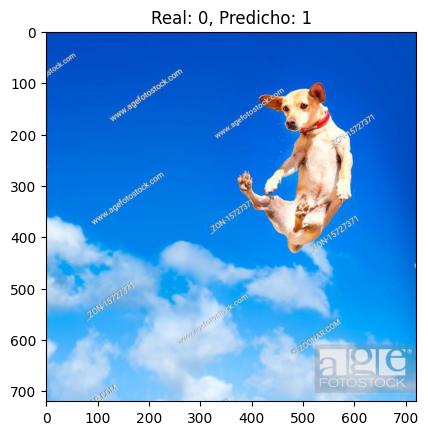

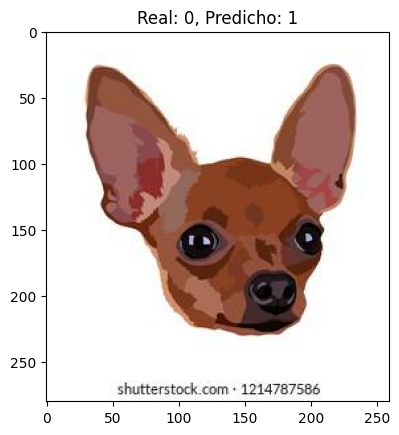

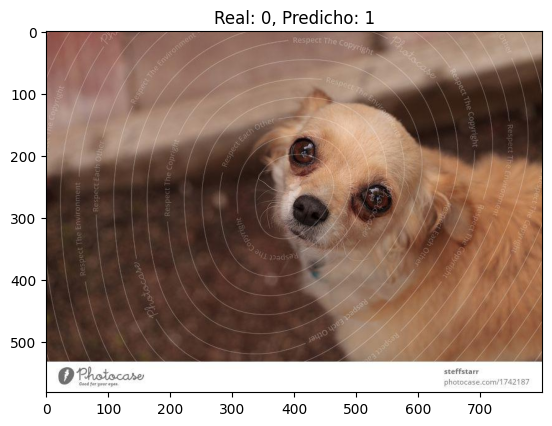

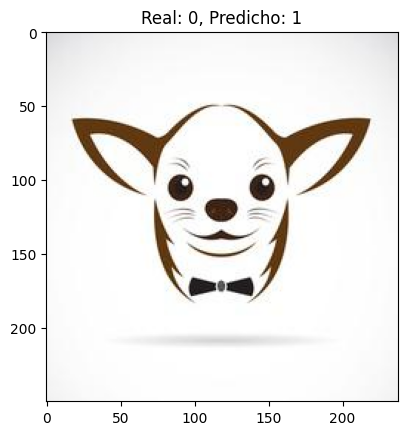

In [ ]:

predictions_mlp_adjusted = model_mlp_adjusted.predict(test_generator)
predicted_classes = np.round(predictions_mlp_adjusted).astype('int').reshape(-1)  # Redondear y cambiar la forma para comparar

# Obtener las etiquetas reales y los nombres de archivo
true_classes = test_generator.classes
filenames = test_generator.filenames

# Identificar los índices de las imágenes mal clasificadas
errors = np.where(predicted_classes != true_classes)[0]

# Mostrar algunas imágenes mal clasificadas
for i, err in enumerate(errors[:5]):  # Cambiar 5 por el número de imágenes que quieras mostrar
    img = plt.imread(os.path.join(test_dir, filenames[err]))
    plt.imshow(img)
    plt.title(f"Real: {true_classes[err]}, Predicho: {predicted_classes[err]}")
    plt.show()


### <font color='blue'>**Conclusiones**</font>

1. Los modelos CNN muestran un rendimiento superior en términos de precisión tanto en el conjunto de entrenamiento como en el conjunto de prueba en comparación a los modelos MLP, lo cual es consistente por su capacidad de capturar características espaciales y patrones en las imágenes. Sin embargo, con una arquitectura y ajustes adecuados los MLP podrían ser útiles en tareas de clasificación de imágenes menos complejas.

2. En cuanto al ajuste de hiperparámetros realizado en los modelos, el número de nodos en las capas ocultas y los filtros en las capas convolucionales, tuvieron un impacto significativo en el rendimiento. Por ejemplo:

    - El modelo "MLP_adjusted" mostró una disminución en la precisión en comparación con el modelo "MLP", lo que podría indicar un sobreajuste debido al aumento del número de nodos y por otra parte, el uso de Dropout que intentó mitigar este problema.
    
    - Por otra parte, "CNN_adjusted" mejoró en precisión sobre el test en comparación al modelo CNN original, lo que sugiere que los ajustes en este caso fueron beneficiosos.

3. En cuanto a la aplicación de Data Augmentation, se aplicó para asegurar un modelo que fuera más robusto al entrenarse con variaciones de las imágenes originales. Para validar la eficacia de esta técnica, entrenamos la red CNN sin aplicar ninguna técnica de distorsión (sólo estandarizando los pixeles). Los resultados fueron:







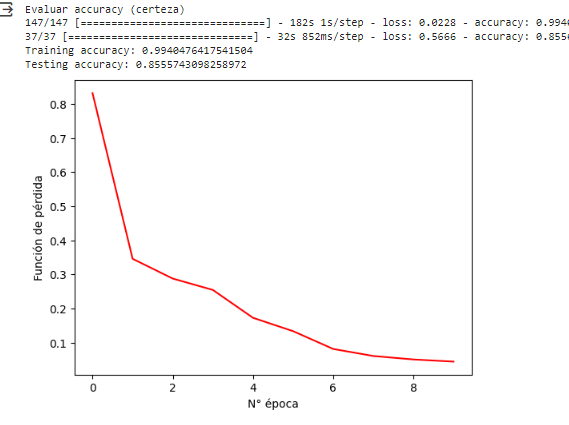

Se ve como **sin aplicar data augmentation se obtuvo un accuracy sobre test de 85,5%.** Si lo comparamos con el accuracy, **aplicando data augmentation, de 84,8%** vemos que incluso sube unas décimas, es decir, el distorsionar la data no tuvo un efecto positivo en la performance.  De esto puede concluirse que quizá el tipo de distorsión aplicado no era el indicado dado el tipo de imágenes, por lo que se sugiere probar "otro tipo de ruidos" para ver si con ellos si mejora la performance original.



4. Se destaca la importancia de la arquitectura de la red para mejorar el rendimiento del modelo, considerando el número y tamaño de las capas. Por ejemplo, "CNN_adjusted_2" tiene una arquitectura más simplificada en comparación a "CNN_adjusted", pero aún así mantiene un rendimiento comparable, lo que indica que una red más simple puede ser suficiente para este conjunto de datos.

5. Se sugiere además incorporar en los modelos la técnica early stopping, totalmente útil en estos casos en que el tiempo de cómputo es extenso. Además de poder escoger la iteración definitica del modelo (hasta ahora siempre nos quedamos con la última época)
Por ejemplo en las siguientes épocas:



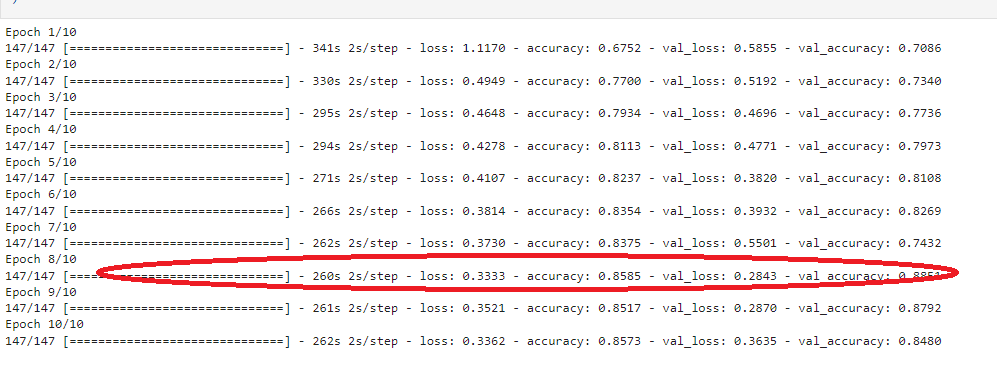

quizá lo deseable era quedarse con la iteración o época 8, que presentana la menor "pérdida" y el mayor accurracy en la validación.

6. Finalmente, los valores de la curva ROC (AUC) son relativamente bajos para los modelos CNN. Lo que sugiere que aunque los modelos son precisos en términos de clasificación, su capacidad para discriminar entre las clases (muffin vs chiuahua) no es tan fuerte, por lo tanto, se sugiere mejorar el ajuste de los modelos, para obtener un AUC más alta y en consecuencia un mejor rendimiento de los modelos en cuanto a sensibilidad y especificidad.